Importing necessary packages

In [2]:
import os
import ast
import wfdb
import random
import numpy as np
import pandas as pd
import pywt

import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, AveragePooling1D, GlobalAveragePooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
import graphviz
from numba import cuda
from tcn import TCN

Loading the ptbxl database and scp(standard communication protocol) statements csv files to read essential data for classification
* ptbxl_database: Contains the data of the patients (essential data: ecg_id, filename_lr, scp_codes)
* scp_statements: Contains the scp codes and their corresponding diagnostic statements (required for generating diagnostic superclass labels for multiclass classification)

In [3]:
PATH = 'ptbxl/'

ecg_df = pd.read_csv(os.path.join(PATH, 'ptbxl_database.csv'), index_col='ecg_id')
ecg_df.scp_codes = ecg_df.scp_codes.apply(lambda x : ast.literal_eval(x))

agg_df = pd.read_csv(os.path.join(PATH, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

LEAD_NAMES = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
# ecg_df.head()

aggregate_diagnostic() : function that takes the scp codes of a patient and returns the superclass labels for multiclass classification by mapping the scp codes to the diagnostic statements in the scp_statements csv file

In [4]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [5]:
ecg_df['diagnostic_superclass'] = ecg_df.scp_codes.apply(aggregate_diagnostic)

load_raw_data() : function to load raw data from the files, wfdb package is used to read the .dat files from the PATH

In [6]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [7]:
ecg_data = load_raw_data(ecg_df, 100, PATH)

In [8]:
ecg_data.shape

(21799, 1000, 12)

Initially data is loaded in the shape (21799, 1000, 12) <br>
The data is then reshaped to (21799, 12, 1000) for logical purposes. <br>
The shape (12, 1000) represents 1000 samples for each of the 12 leads attached to the patient.

In [12]:
ecg_data = np.transpose(ecg_data, (0, 2, 1))
ecg_data.shape

(21799, 12, 1000)

Plotting the ECG signals for one patient for visualization purpose

/tmp/ipykernel_2427/2158001277.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 2000x500 with 0 Axes>

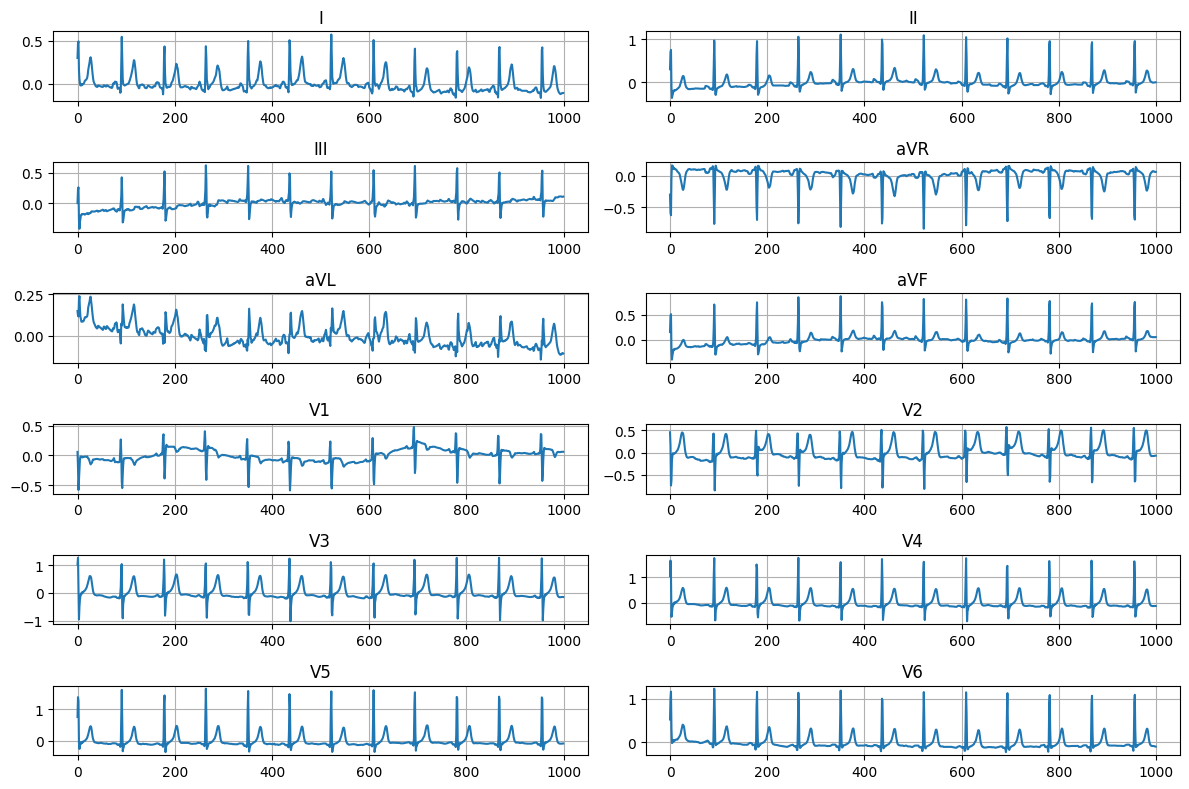

In [13]:
idx = random.randint(0, ecg_data.shape[0])
plt.figure(figsize=(20, 5))
data = ecg_data[idx]
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(6, 2, i + 1)
    plt.plot(data[i])
    plt.title(LEAD_NAMES[i])
    plt.grid()
    plt.tight_layout()

# plt.suptitle(y[idx])
plt.show()

#### Feature Extraction: <br>
Discrete Wavelet Transform (DWT) is used to extract features from the ECG signals. <br>
The five most significant coefficients are extracted from the DWT of the ECG signals in order to filter out the noise components and retain the essential features. <br>
Harr wavelet is used for the process. <br>


In [14]:
def dwt(signal):
    coeffs = pywt.wavedec(signal, wavelet='haar', level=5)
    return np.concatenate(coeffs)


# Iterate over each patient and lead
ecg_data_dwt = []
for patient_data in ecg_data:
    patient_coeffs = []
    for lead_data in patient_data:
        lead_coeffs = dwt(lead_data)
        patient_coeffs.append(lead_coeffs)
    ecg_data_dwt.append(patient_coeffs)

ecg_data_dwt = np.array(ecg_data_dwt)


#### Visualizing the DWT coefficients for one patient and one lead

In [15]:
coeffs = pywt.wavedec(ecg_data[0][0], wavelet='haar', level=5)
cA1, cD5, cD4, cD3, cD2, cD1 = coeffs

In [16]:
cA1.shape, cD5.shape, cD4.shape, cD3.shape, cD2.shape, cD1.shape

((32,), (32,), (63,), (125,), (250,), (500,))

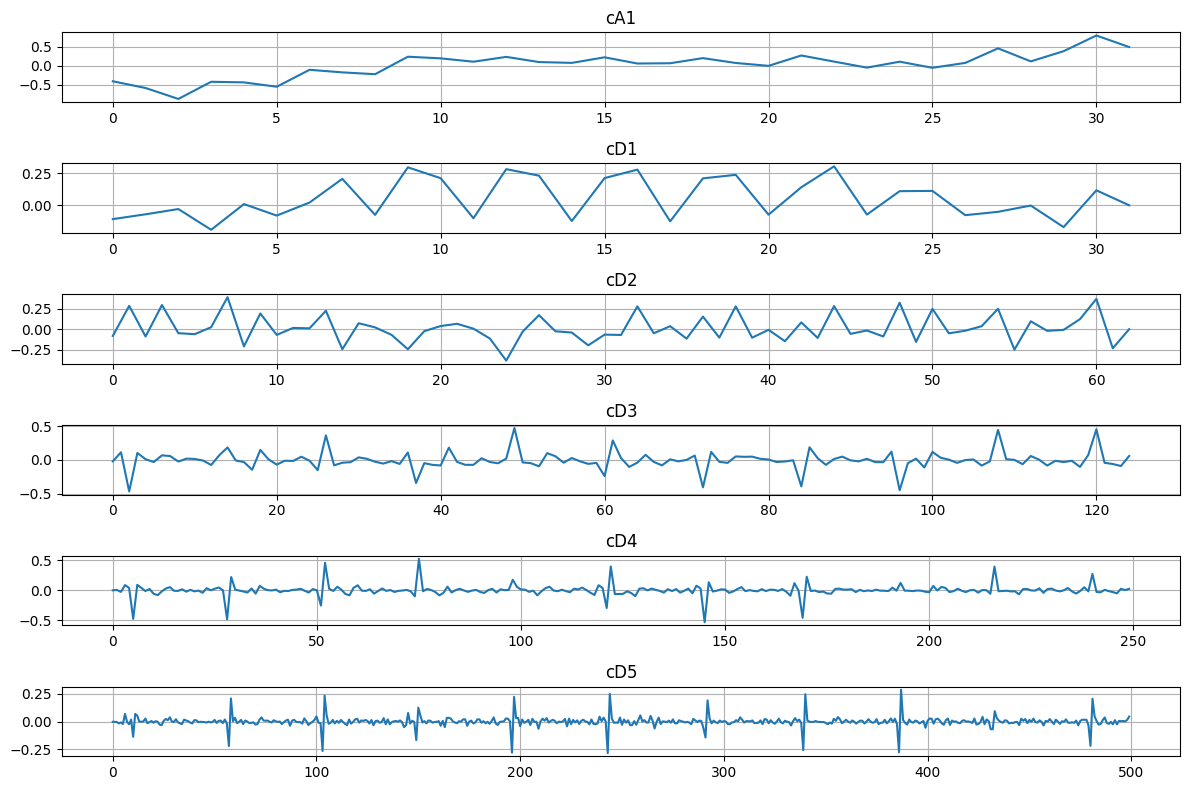

In [17]:
coeffs = pywt.wavedec(ecg_data[0][0], wavelet='haar', level=5)

# extract the coeffs cA1, cD5, cD4, cD3, cD2, cD1 from the concatenated coeffs

plt.figure(figsize=(12, 8))
for i, coeff in enumerate(coeffs):
    if i == 0:
        label = 'cA1'
    else:
        label = f'cD{i}'
    plt.subplot(6, 1, i+1)
    plt.plot(coeff)
    plt.title(label)
    plt.grid()

plt.tight_layout()
plt.show()
plt.show()

Exploring the datafram to identify essential columns

In [18]:
ecg_df.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]


#### Isolating the labels from the datafram for cleaner workspace and better understanding

In [19]:
labels = ecg_df[['diagnostic_superclass']].copy()

In [20]:
# display all the unique diagnostic_superclass combinations present
labels['diagnostic_superclass'].value_counts()

diagnostic_superclass
[NORM]                 9069
[MI]                   2532
[STTC]                 2400
[CD]                   1708
[CD, MI]               1297
[STTC, HYP]             781
[STTC, MI]              599
[HYP]                   535
[CD, STTC]              471
[]                      411
[CD, NORM]              407
[HYP, MI, STTC]         337
[CD, HYP]               300
[HYP, MI]               183
[CD, STTC, HYP]         127
[CD, MI, STTC]          118
[CD, STTC, MI]          105
[CD, MI, HYP]            95
[CD, HYP, MI, STTC]      94
[CD, HYP, STTC]          84
[CD, MI, STTC, HYP]      50
[STTC, NORM]             28
[CD, HYP, MI]            22
[STTC, MI, HYP]          21
[CD, STTC, MI, HYP]      10
[CD, STTC, NORM]          5
[STTC, HYP, MI]           3
[CD, STTC, HYP, MI]       2
[CD, HYP, NORM]           2
[HYP, NORM]               2
[CD, MI, NORM, HYP]       1
Name: count, dtype: int64

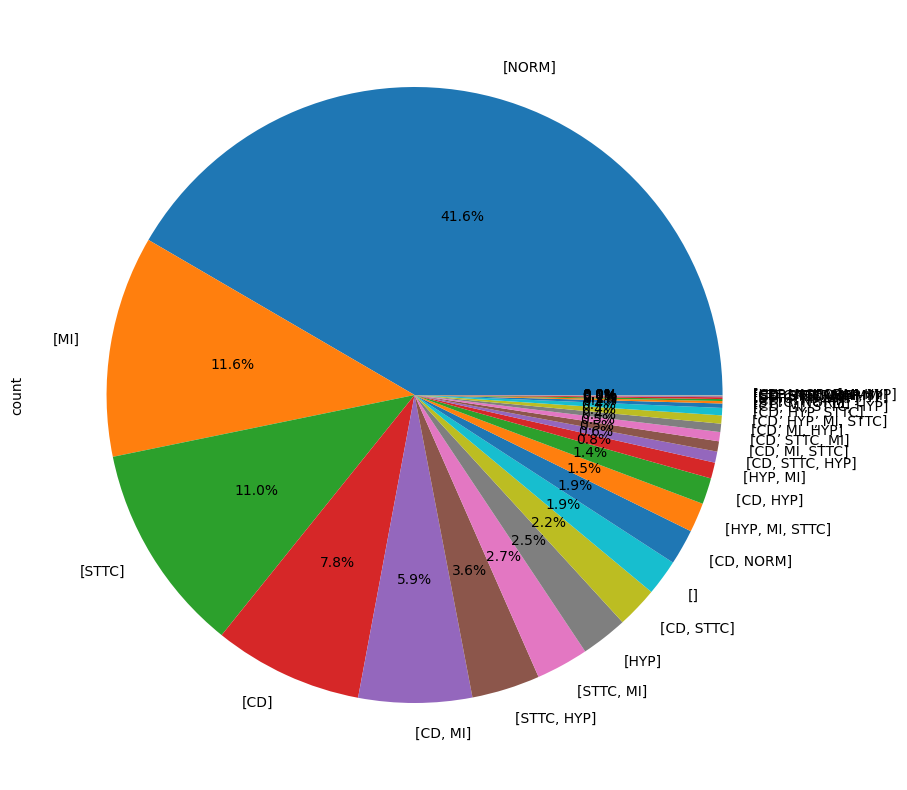

In [21]:
# plot the value counts in a piechart
plt.figure(figsize=(10, 10))
labels['diagnostic_superclass'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

##### Plotting the distribuiton of data for each superclass and it's combinations

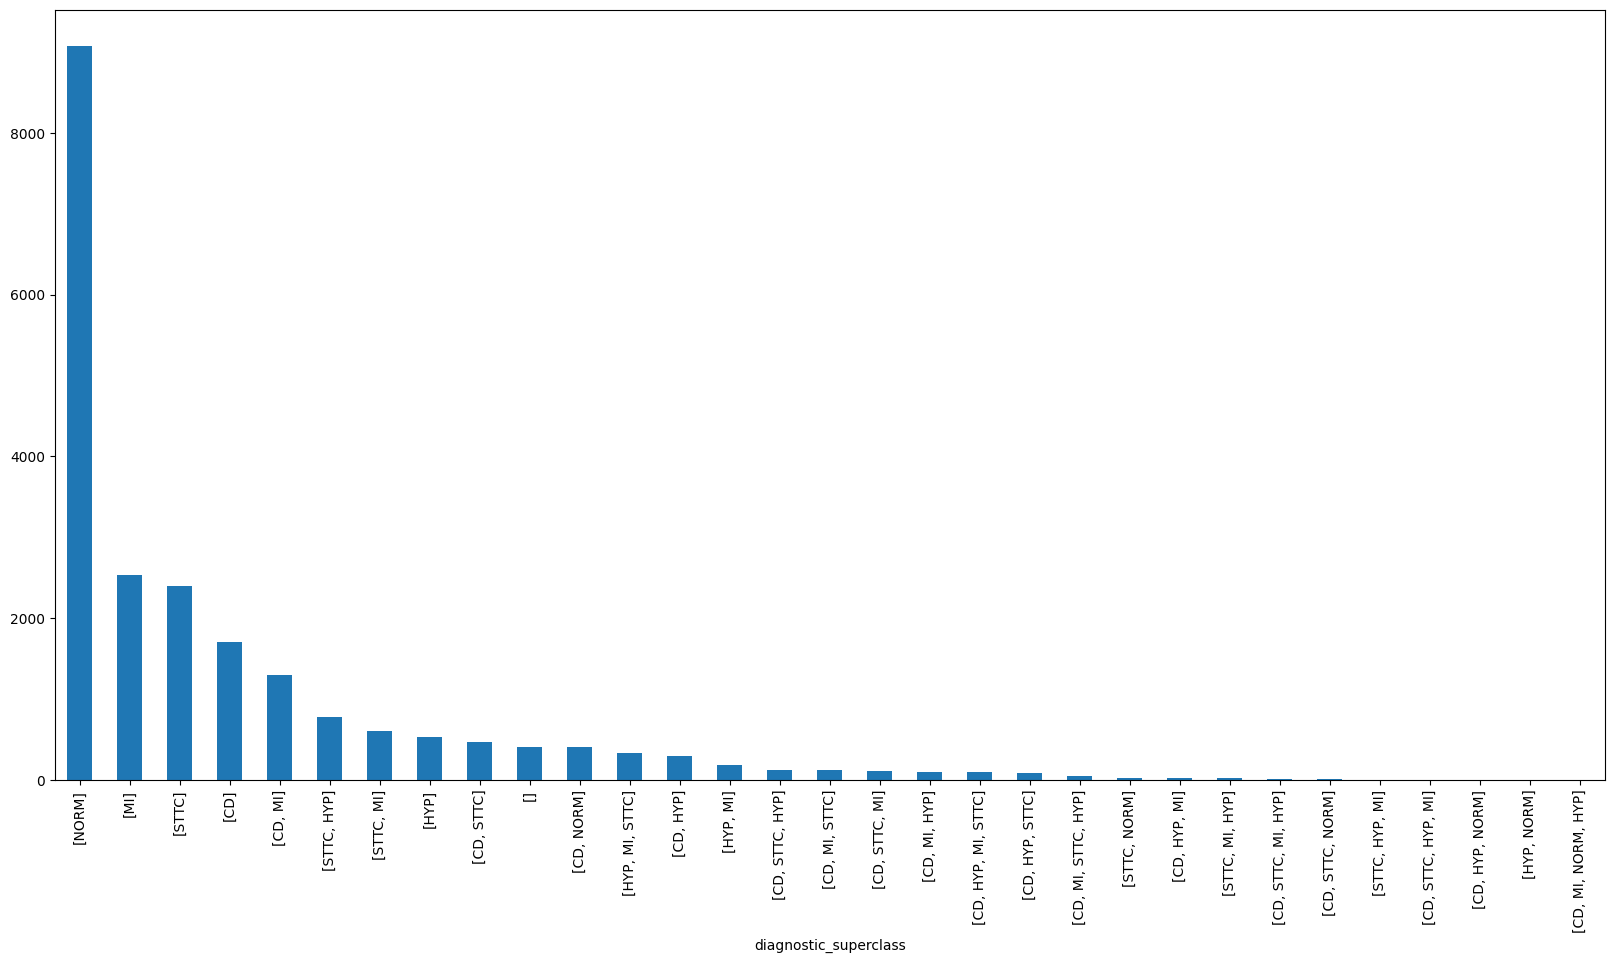

In [22]:
# plot the count of every diagnostic superclass
plt.figure(figsize=(20, 10))
labels.diagnostic_superclass.value_counts().plot(kind='bar')
plt.show()

#### Filter out the labels and the ecg dwt data for five class classification
The data belonging to the individual superclasses "NORM", "STTC", "MI", "CD", "HYP" are filtered out by going through the entire dataframe and extracting the data that belongs to the respective superclass. <br>

In [23]:
# filter out only datas and corresponding labels with diagnostic superclass of 'NORM' , 'MI', 'STTC', 'CD' and 'HYP'
ecg_data_filtered = []
labels_filtered = []
for i in range(len(labels)):
    list = labels.iloc[i].diagnostic_superclass
    if (list == ['NORM'] or list == ['MI'] or list == ['STTC'] or list == ['CD'] or list == ['HYP']):
        ecg_data_filtered.append(ecg_data_dwt[i])
        labels_filtered.append(list)


In [24]:
ecg_data_filtered = np.array(ecg_data_filtered)
labels_filtered = np.array(labels_filtered)
ecg_data_filtered.shape, labels_filtered.shape

((16244, 12, 1002), (16244, 1))

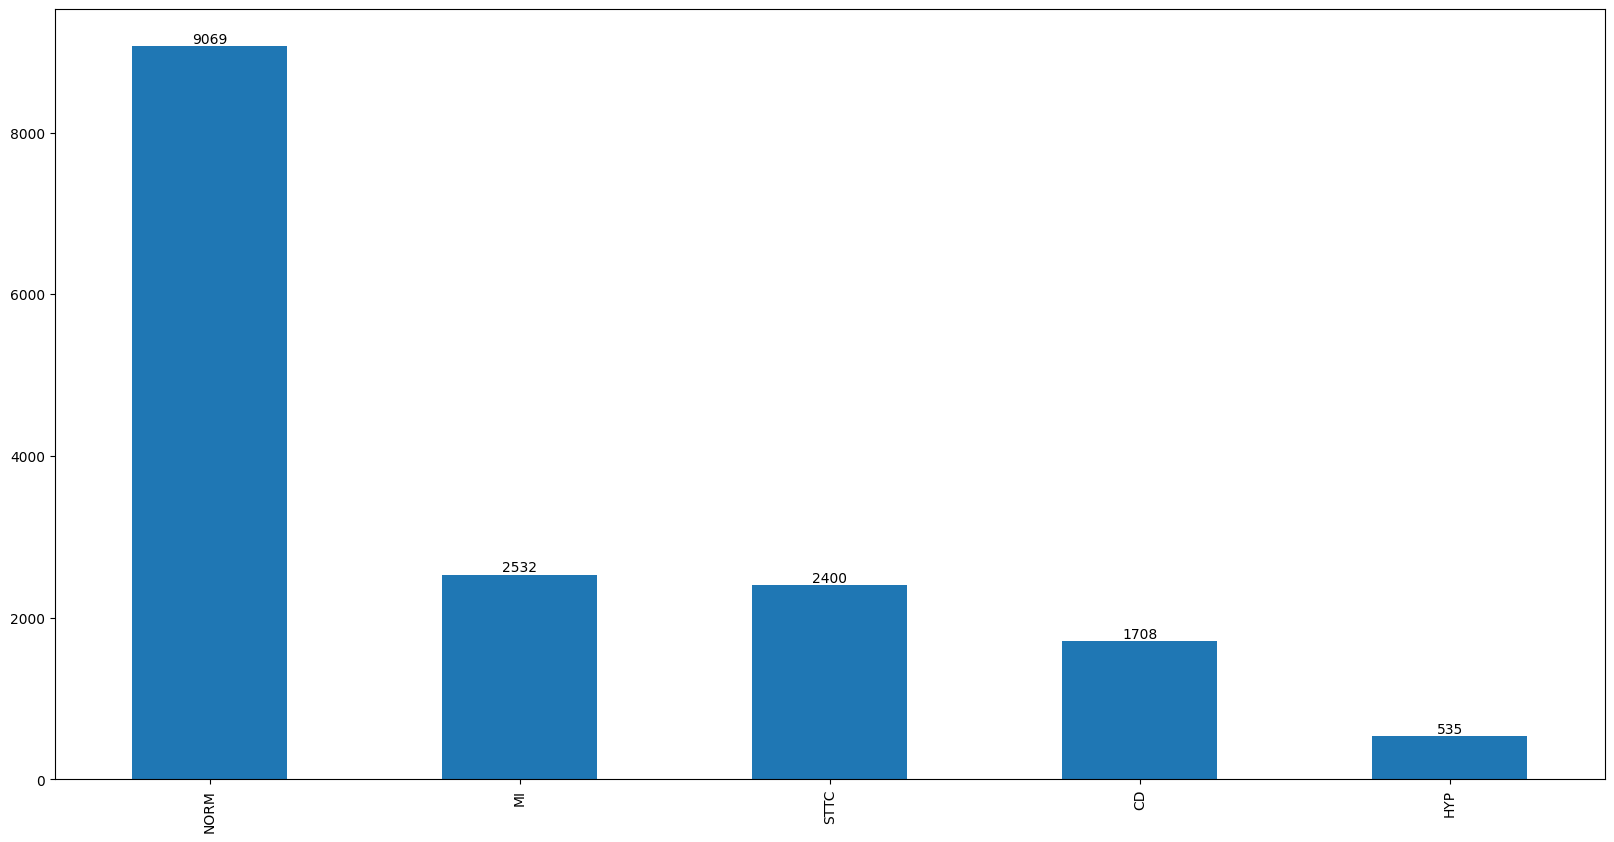

In [25]:
# plot the filtered labels count in a bar graph
plt.figure(figsize=(20, 10))
ax = pd.Series(labels_filtered.flatten()).value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.show()

#### Creating  a separate label set for binary classification among the classes "NORM" (0) and "ABNORM" (1)

In [26]:
Y_binary = []
for list in labels_filtered:
        if list == ['NORM']:
            Y_binary.append(0)
        else:
            Y_binary.append(1)


Encoding the labels from string to categorical classes for training and testing purposes

In [27]:
labelEncoder = LabelEncoder()
Y_multiclass = labelEncoder.fit_transform(labels_filtered)
Y_multiclass = to_categorical(Y_multiclass)

/run/media/sourav/HDD/Programs/Python/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Visualizing the distribution of normal and abnormal data

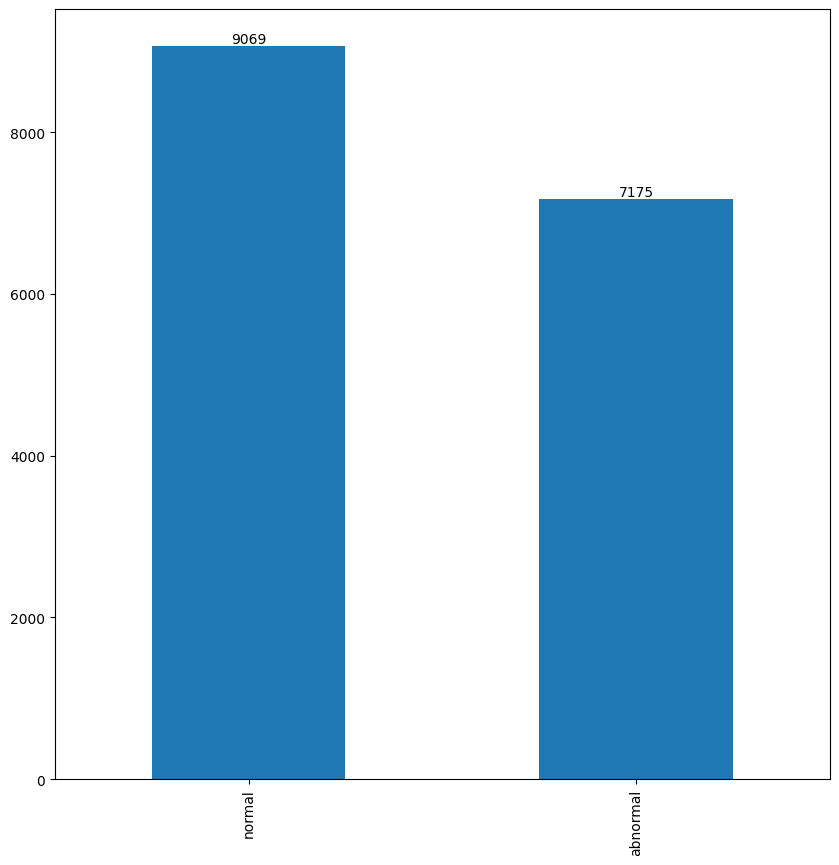

0    9069
1    7175
Name: count, dtype: int64

In [28]:
plt.figure(figsize=(10, 10))
ax = pd.Series(Y_binary).value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1], ['normal', 'abnormal'])
plt.show()

pd.Series(Y_binary).value_counts()

In [29]:
Y_binary = np.array(Y_binary)
Y_binary.shape

(16244,)

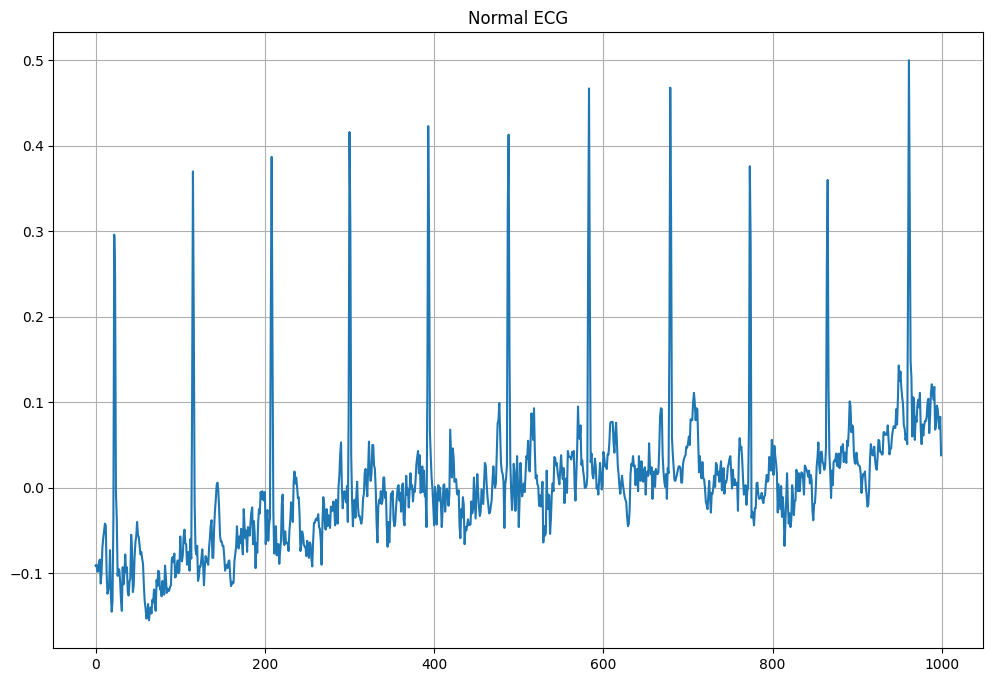

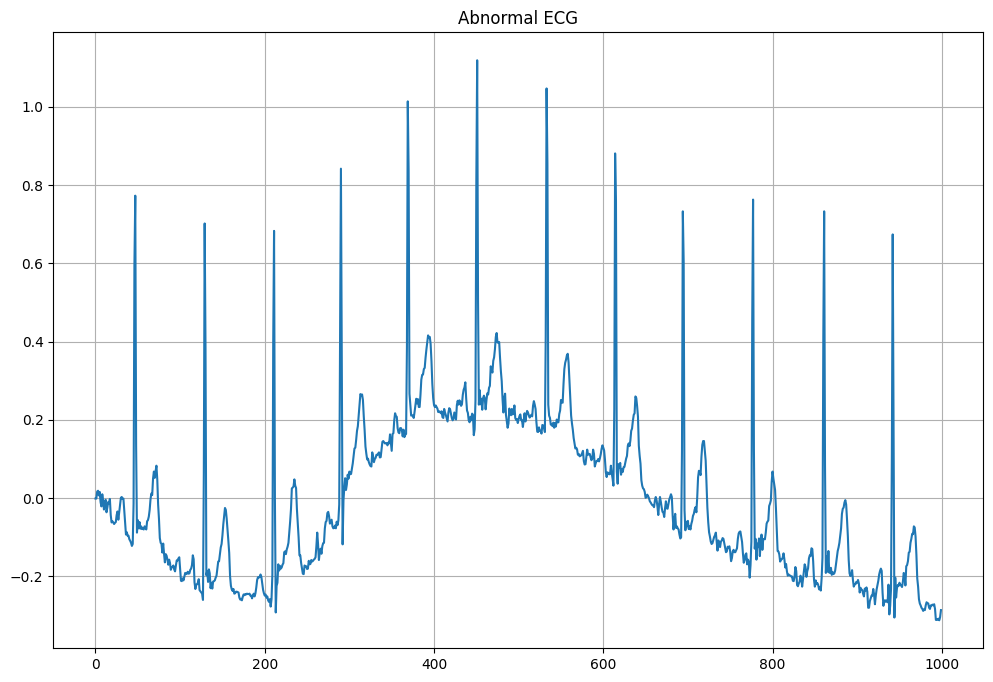

In [32]:
# plot one normal and one abnormal signal
normal_idx = np.where(Y_binary == 0)[0]
abnormal_idx = np.where(Y_binary == 1)[0]

plt.figure(figsize=(12, 8))
plt.plot(ecg_data[normal_idx[0]][4])
plt.title('Normal ECG')
plt.grid()
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(ecg_data[abnormal_idx[0]][4])
plt.title('Abnormal ECG')
plt.grid()
plt.show()

#### Splitting the data into training and testing sets

In [33]:
x_train_binary, x_test_binary, y_train_binary, y_test_binary = train_test_split(ecg_data_filtered, Y_binary, test_size=0.2, random_state=42)
x_valid_binary, y_valid_binary = x_test_binary, y_test_binary

Validation sets used in training are same as testing sets

In [36]:
x_train_binary.shape, x_test_binary.shape, y_train_binary.shape, y_test_binary.shape

((12995, 12, 1002), (3249, 12, 1002), (12995,), (3249,))

In [37]:
x_train_multiclass, x_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(ecg_data_filtered, Y_multiclass, test_size=0.2, random_state=42)
x_valid_multiclass, y_valid_multiclass = x_test_multiclass, y_test_multiclass

In [38]:
x_train_multiclass.shape, x_valid_multiclass.shape, y_train_multiclass.shape, y_valid_multiclass.shape

((12995, 12, 1002), (3249, 12, 1002), (12995, 5), (3249, 5))

#### Visualizing the train - test split for the binary classification and the five class classification

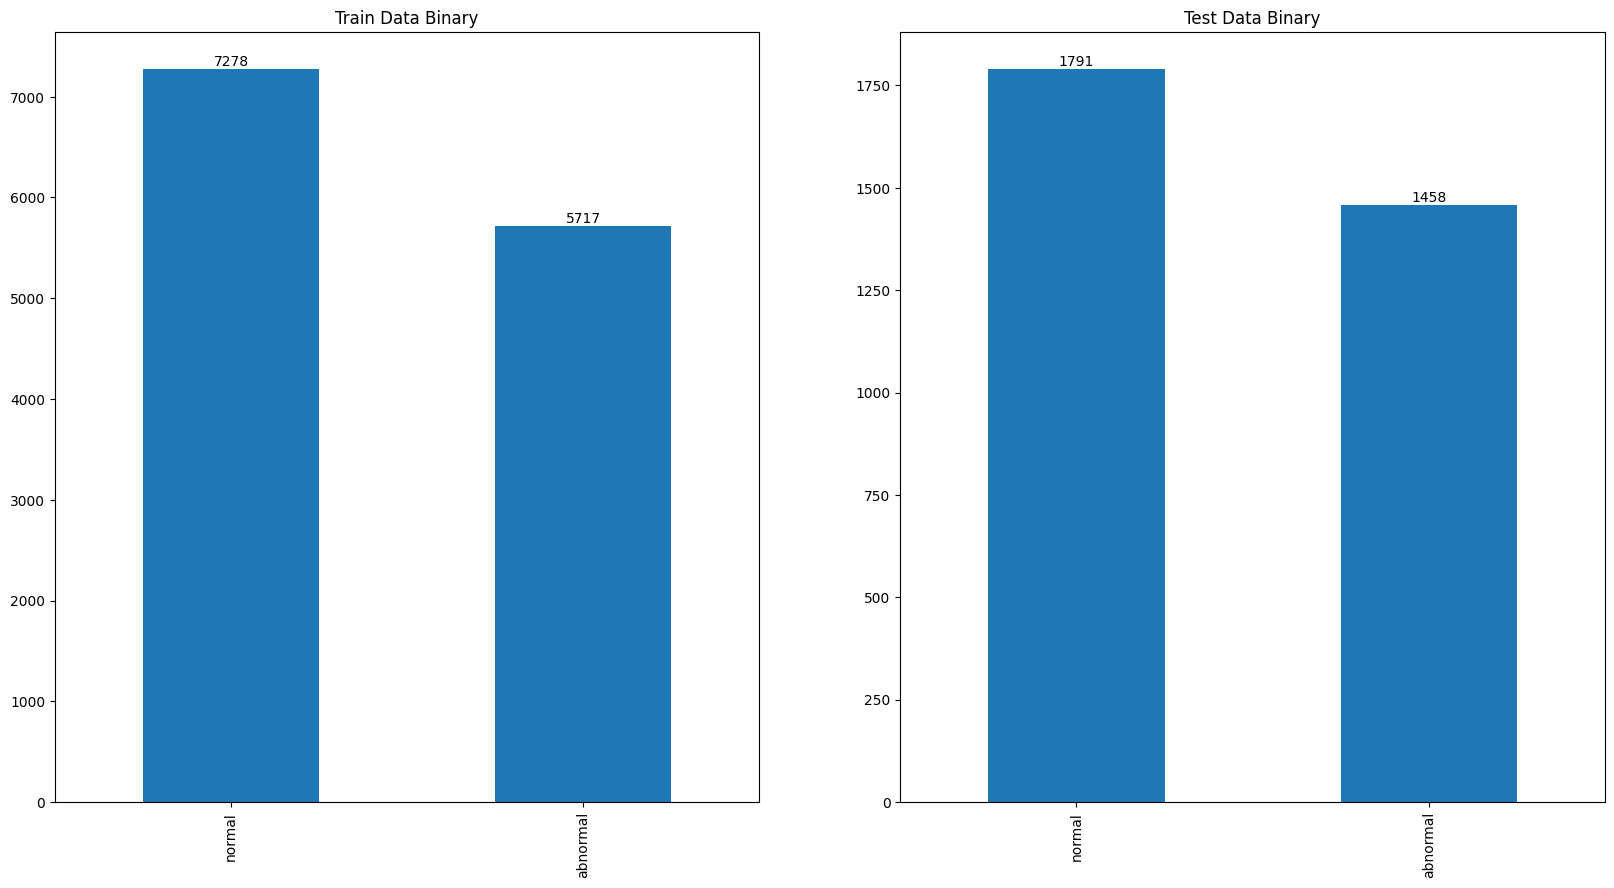

In [34]:
plt.figure(figsize=(20, 10))

# Plot train data
plt.subplot(1, 2, 1)
ax_train = pd.Series(y_train_binary).value_counts().plot(kind='bar')
for p in ax_train.patches:
    ax_train.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1], ['normal', 'abnormal'])
plt.title(f'Train Data Binary')

# Plot test data
plt.subplot(1, 2, 2)
ax_test = pd.Series(y_test_binary).value_counts().plot(kind='bar')
for p in ax_test.patches:
    ax_test.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1], ['normal', 'abnormal'])
plt.title(f'Test Data Binary')

plt.show()


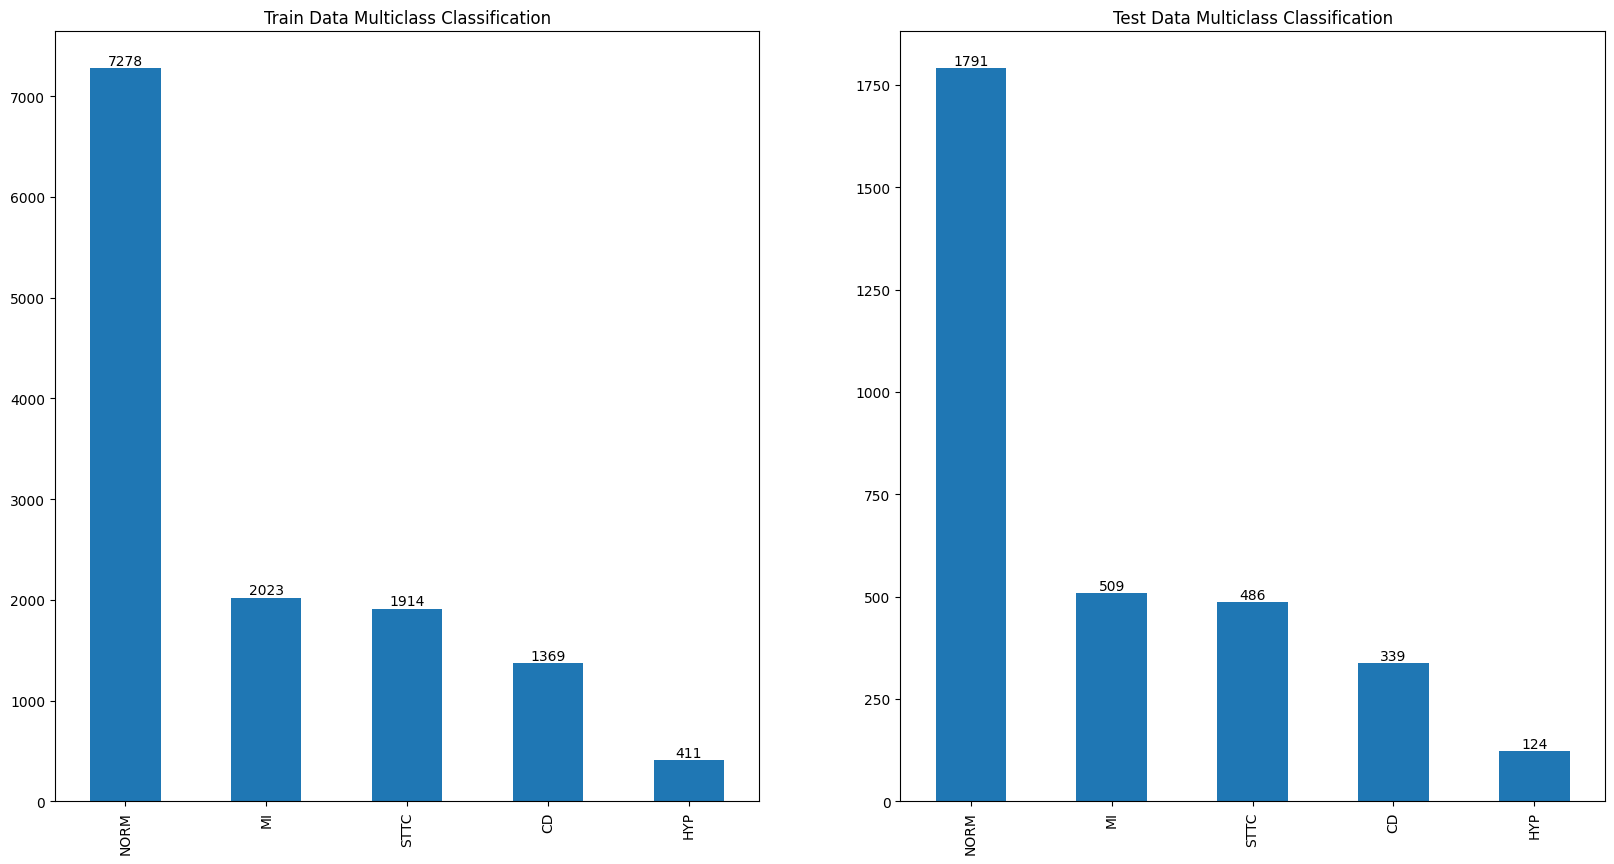

In [39]:
plt.figure(figsize=(20, 10))

# Plot train data
plt.subplot(1, 2, 1)
ax_train = pd.Series(y_train_multiclass.argmax(axis=1)).value_counts().plot(kind='bar')
for p in ax_train.patches:
    ax_train.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1, 2, 3, 4], ['NORM', 'MI', 'STTC', 'CD', 'HYP'])
plt.title('Train Data Multiclass Classification')

# Plot test data
plt.subplot(1, 2, 2)
ax_test = pd.Series(y_test_multiclass.argmax(axis=1)).value_counts().plot(kind='bar')
for p in ax_test.patches:
    ax_test.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
plt.xticks([0, 1, 2, 3, 4], ['NORM', 'MI', 'STTC', 'CD', 'HYP'])
plt.title('Test Data Multiclass Classification')

plt.show()



### Training and testing the models

#### 1D CNN model for five class classification

In [41]:
def build_model_cnn_multiclass(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

    return model;

## Classification using 1 lead ECG signal

In [42]:
x_train_single_lead = x_train_multiclass[:, 0, :]
x_train_single_lead = x_train_single_lead.reshape(x_train_single_lead.shape[0], x_train_single_lead.shape[1], 1)
x_valid_single_lead = x_valid_multiclass[:, 0, :]
x_valid_single_lead = x_valid_single_lead.reshape(x_valid_single_lead.shape[0], x_valid_single_lead.shape[1], 1)
x_test_single_lead = x_test_multiclass[:, 0, :]
x_test_single_lead = x_test_single_lead.reshape(x_test_single_lead.shape[0], x_test_single_lead.shape[1], 1)

In [44]:
model_cnn_single_lead = build_model_cnn_multiclass((x_train_single_lead.shape[1], x_train_single_lead.shape[2]))
model_cnn_single_lead.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 1002, 64)          448       
                                                                 
 batch_normalization_3 (Bat  (None, 1002, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 501, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 501, 64)           24640     
                                                                 
 batch_normalization_4 (Bat  (None, 501, 64)           256       
 chNormalization)                                                
                                                      

In [45]:
model_cnn_single_lead.fit(x_train_single_lead, y_train_multiclass, validation_data=(x_valid_single_lead, y_valid_multiclass), epochs=20, batch_size=32, callbacks=[EarlyStopping(patience=5)])

2024-04-03 20:29:03.947451: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52083960 exceeds 10% of free system memory.
2024-04-03 20:29:05.438983: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52083960 exceeds 10% of free system memory.


Epoch 1/20


2024-04-03 20:29:10.007927: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-03 20:29:15.994827: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-03 20:29:16.048744: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-03 20:29:18.564467: I external/local_xla/xla/service/service.cc:168] XLA service 0x7d95714f77e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 20:29:18.564532: I external/local_xla/xla/service/service.

407/407 [==============================] - 28s 22ms/step - loss: 2.0248 - accuracy: 0.2534 - val_loss: 1.5787 - val_accuracy: 0.2465
Epoch 2/20
407/407 [==============================] - 7s 16ms/step - loss: 1.5706 - accuracy: 0.3415 - val_loss: 1.3935 - val_accuracy: 0.5383
Epoch 3/20
407/407 [==============================] - 7s 16ms/step - loss: 1.5251 - accuracy: 0.3826 - val_loss: 1.3674 - val_accuracy: 0.5552
Epoch 4/20
407/407 [==============================] - 7s 16ms/step - loss: 1.4781 - accuracy: 0.4182 - val_loss: 1.3291 - val_accuracy: 0.5639
Epoch 5/20
407/407 [==============================] - 7s 16ms/step - loss: 1.4413 - accuracy: 0.4418 - val_loss: 1.2728 - val_accuracy: 0.5682
Epoch 6/20
407/407 [==============================] - 7s 16ms/step - loss: 1.4054 - accuracy: 0.4670 - val_loss: 1.2670 - val_accuracy: 0.5749
Epoch 7/20
407/407 [==============================] - 6s 16ms/step - loss: 1.3834 - accuracy: 0.4740 - val_loss: 1.2503 - val_accuracy: 0.5756
Epoch 8/2

In [46]:
loss, accuracy = model_cnn_single_lead.evaluate(x_test_single_lead, y_test_multiclass)

102/102 [==============================] - 1s 6ms/step - loss: 1.1203 - accuracy: 0.5833


#### train_model_for_all_leads() : 
function to train the model for all the 12 leads and output a table of validation/testing accuracy values obtained from each lead. The function performs the exact same operation as the above three cells for one lead - five class classification, but iterates through all the 12 leads. <br>

**WARNING**: The function takes a long time to run (around 1hr) as it trains the model for all the 12 leads.

In [48]:
# write a function to perform the operation of the above 3 cells for all the leads and store the loss and accuracy in a list 
def train_model_for_all_leads(x_train, y_train, x_valid, y_valid, x_test, y_test):
    loss_list = []
    accuracy_list = []
    for i in range(x_train.shape[1]):
        x_train_single_lead = x_train[:, i, :]
        x_train_single_lead = x_train_single_lead.reshape(x_train_single_lead.shape[0], x_train_single_lead.shape[1], 1)
        x_valid_single_lead = x_valid[:, i, :]
        x_valid_single_lead = x_valid_single_lead.reshape(x_valid_single_lead.shape[0], x_valid_single_lead.shape[1], 1)
        x_test_single_lead = x_test[:, i, :]
        x_test_single_lead = x_test_single_lead.reshape(x_test_single_lead.shape[0], x_test_single_lead.shape[1], 1)
        
        model_cnn_single_lead = build_cnn_model((x_train_single_lead.shape[1], x_train_single_lead.shape[2]))
        model_cnn_single_lead.fit(x_train_single_lead, y_train, validation_data=(x_valid_single_lead, y_valid), epochs=20, batch_size=32, callbacks=[EarlyStopping(patience=5)])
        loss, accuracy = model_cnn_single_lead.evaluate(x_test_single_lead, y_test)
        loss_list.append(loss)
        accuracy_list.append(accuracy)
    return loss_list, accuracy_list

In [ ]:
loss_list, accuracy_list = train_model_for_all_leads(x_train, y_train, x_valid, y_valid, x_test, y_test)

In [ ]:
# crate a dataframe of the accuracy list for all the lists and display i
# create a dataframe of the accuracy list for all the leads and display it
accuracy_df = pd.DataFrame({'Lead Names': LEAD_NAMES, 'Accuracy': accuracy_list})
accuracy_df


#### Using RandomForest Classifier for the same task

In [47]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_single_lead.reshape(x_train_single_lead.shape[0], x_train_single_lead.shape[1]), y_train_binary)

RandomForestClassifier(random_state=42)

In [39]:
Y_pred = rf.predict(x_test_single_lead.reshape(x_test_single_lead.shape[0], x_test_single_lead.shape[1]))

In [41]:
accuracy = accuracy_score(y_test_binary, Y_pred)
print("Random Forest Accuracy for single lead testing: ", accuracy)

Random Forest Accuracy for single lead testing 0.6358879655278548


#### random_forest_for_all_leads() :
function to train the model for all the 12 leads individually and output a table of validation/testing accuracy values obtained from each lead. The function performs the exact same operation as the above three cells for one lead - five class classification, but iterates through all the 12 leads. <br>

In [49]:
# write a function to perfom random forest classification for all the leads and return the accuracy
def random_forest_classification_all_leads(x_train, y_train, x_test, y_test):
    accuracy_list = []
    for i in range(x_train.shape[1]):
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(x_train[:, i, :], y_train)
        Y_pred = rf.predict(x_test[:, i, :])
        accuracy = accuracy_score(y_test, Y_pred)
        accuracy_list.append(accuracy)
    return accuracy_list

In [43]:
accuracy_list_rf = random_forest_classification_all_leads(x_train_binary, y_train_binary, x_test_binary, y_test_binary)

In [45]:
# create a dataframe of the accuracy list for all the leads and display it
# create a dataframe of the accuracy list for all the leads
accuracy_df_rf = pd.DataFrame({'Lead Names': LEAD_NAMES, 'Accuracy': accuracy_list_rf})

# display the dataframe with the specified title
print("Accuracy of single lead under Random Forest Classification")
accuracy_df_rf

Accuracy of single lead under Random Forest Classification


,Lead Names,Accuracy
0,I,0.635888
1,II,0.641120
2,III,0.637427
3,aVR,0.678978
4,aVL,0.632502
5,aVF,0.624808
6,V1,0.644814
7,V2,0.627886
8,V3,0.650662
9,V4,0.689443


## Subproblem - 2 : Using leads (2, 4, 6, 12)

Using the leads 2, 4, 6 and 12 together for five class classification to compare if the model performs better with more than one lead for classification. <br>

In [50]:
x_train_4lead = x_train_multiclass[:, [1, 3, 5, 11], :]
x_train_4lead = x_train_4lead.reshape(x_train_4lead.shape[0], 4, x_train_4lead.shape[2])
x_valid_4lead = x_valid_multiclass[:, [1, 3, 5, 11], :]
x_valid_4lead = x_valid_4lead.reshape(x_valid_4lead.shape[0], 4, x_valid_4lead.shape[2])
x_test_4lead = x_test_multiclass[:, [1, 3, 5, 11], :]
x_test_4lead = x_test_4lead.reshape(x_test_4lead.shape[0], 4, x_test_4lead.shape[2])


#### Using CNN for (2, 4, 6, 12) leads

In [51]:
model_cnn_4_lead = build_model_cnn_multiclass((x_train_4lead.shape[1], x_train_4lead.shape[2]))

In [52]:
history = model_cnn_4_lead.fit(x_train_4lead, y_train_multiclass, validation_data=(x_valid_4lead, y_valid_multiclass), epochs=30, batch_size=20, callbacks=[EarlyStopping(patience=5)])

Epoch 1/30


2024-04-03 20:38:46.359529: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 208335840 exceeds 10% of free system memory.
2024-04-03 20:38:46.986476: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 208335840 exceeds 10% of free system memory.


650/650 [==============================] - ETA: 0s - loss: 2.1546 - accuracy: 0.2298

2024-04-03 20:39:00.923911: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 52087968 exceeds 10% of free system memory.


650/650 [==============================] - 15s 14ms/step - loss: 2.1546 - accuracy: 0.2298 - val_loss: 1.6146 - val_accuracy: 0.3167
Epoch 2/30
650/650 [==============================] - 7s 11ms/step - loss: 1.9115 - accuracy: 0.2923 - val_loss: 1.4985 - val_accuracy: 0.4478
Epoch 3/30
650/650 [==============================] - 7s 11ms/step - loss: 1.7708 - accuracy: 0.3418 - val_loss: 1.4348 - val_accuracy: 0.5051
Epoch 4/30
650/650 [==============================] - 8s 12ms/step - loss: 1.6743 - accuracy: 0.3798 - val_loss: 1.3880 - val_accuracy: 0.5300
Epoch 5/30
650/650 [==============================] - 7s 11ms/step - loss: 1.6221 - accuracy: 0.4105 - val_loss: 1.3600 - val_accuracy: 0.5383
Epoch 6/30
650/650 [==============================] - 7s 11ms/step - loss: 1.5591 - accuracy: 0.4322 - val_loss: 1.3548 - val_accuracy: 0.5442
Epoch 7/30
650/650 [==============================] - 7s 11ms/step - loss: 1.5285 - accuracy: 0.4402 - val_loss: 1.3435 - val_accuracy: 0.5423
Epoch 8/3

In [53]:
loss, accuracy = model_cnn_4_lead.evaluate(x_test_4lead, y_test_multiclass)

102/102 [==============================] - 1s 5ms/step - loss: 1.2868 - accuracy: 0.5509


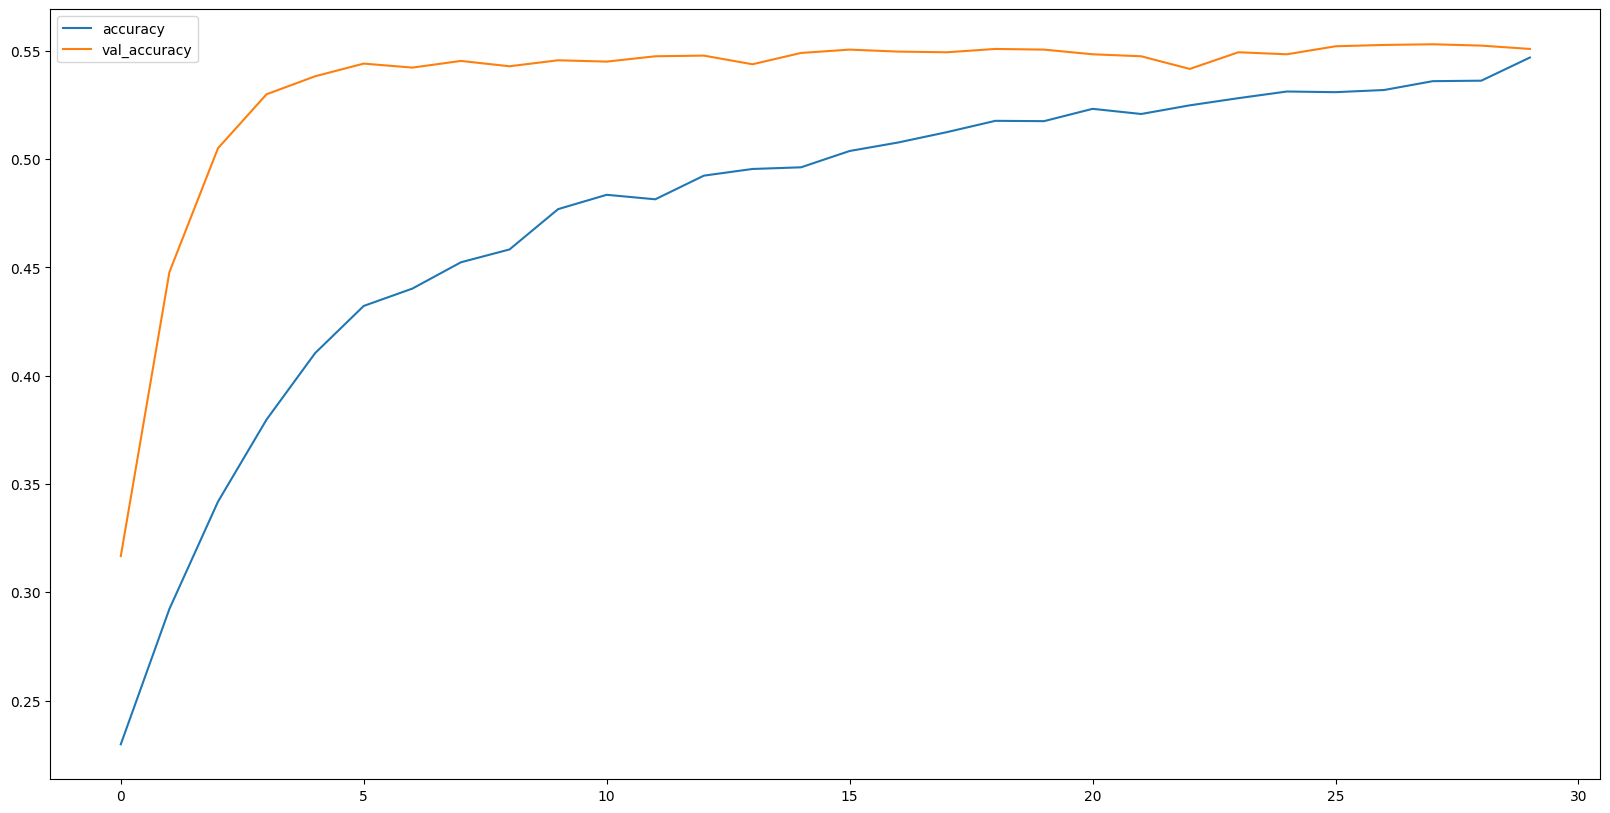

In [54]:
# plot the history of the model
plt.figure(figsize=(20, 10))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

#### Using Random Forest Classification for (2, 4, 6, 12) leads

In [81]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_4lead.reshape(x_train_4lead.shape[0], x_train_4lead.shape[1] * x_train_4lead.shape[2]), y_train_binary)

RandomForestClassifier(random_state=42)

In [82]:
Y_pred = rf.predict(x_test_4lead.reshape(x_test_4lead.shape[0], x_test_4lead.shape[1] * x_test_4lead.shape[2]))

In [84]:
accuracy = accuracy_score(y_test_binary, Y_pred)
print("Random Forest Accuracy for (2, 4, 6, 12) leads multiclass: ", accuracy)

Random Forest Accuracy for (2, 4, 6, 12) leads multiclass:  0.7008310249307479


In [ ]:
# plot the first 3 levels of the random forest classifier
export_graphviz(rf.estimators_[0], out_file='tree.dot', class_names=['normal', 'abnormal'], filled=True, rounded=True)
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

#### Random Forest Visualization
Showing three trees from the random forest that are ensembled to make the final decision. <br>

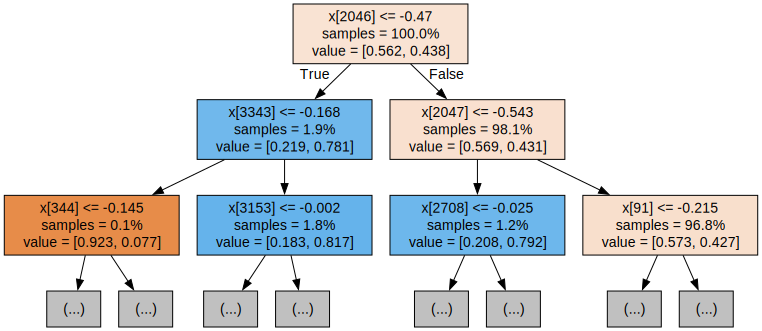

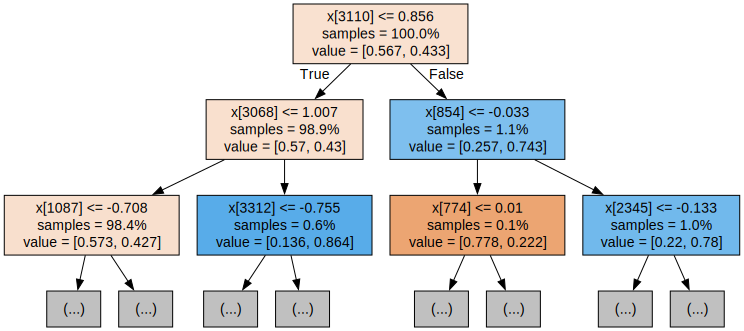

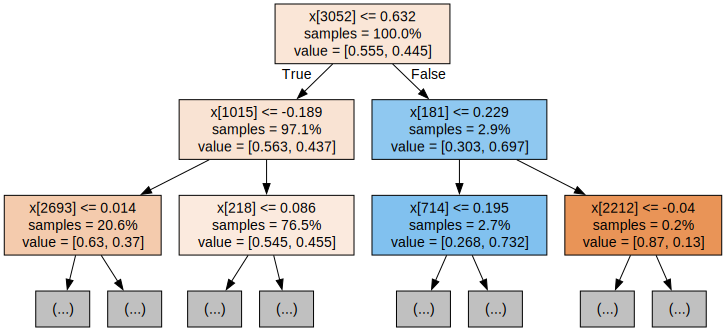

In [88]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## All 12 leads

In [67]:
def build_model_cnn_binary(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=6, activation='relu', 
                    padding='same', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same'))
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Conv1D(filters=32, kernel_size=6, activation='relu', 
                    padding='same'))
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

    return model;

In [68]:
model_cnn_12_leads = build_model_cnn_binary((x_train_binary.shape[1], x_train_binary.shape[2]))

In [69]:
# model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=20, batch_size=12, callbacks=[EarlyStopping(patience=5)])
model_cnn_12_leads.fit(x_train_binary, y_train_binary, validation_data=(x_valid_binary, y_valid_binary), epochs=20, batch_size=12)

Epoch 1/20


2024-04-03 20:53:07.590134: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-03 20:53:07.875120: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-03 20:53:10.080135: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.05GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-03 20:53:10.080195: W external/local_tsl/tsl/framework/bfc_

1075/1083 [============================>.] - ETA: 0s - loss: 0.7045 - accuracy: 0.4401

2024-04-03 20:53:19.358896: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-03 20:53:19.402509: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1083/1083 [==============================] - 15s 10ms/step - loss: 0.7046 - accuracy: 0.4399 - val_loss: 0.6927 - val_accuracy: 0.4488
Epoch 2/20
1083/1083 [==============================] - 10s 9ms/step - loss: 0.6956 - accuracy: 0.4399 - val_loss: 0.6918 - val_accuracy: 0.4488
Epoch 3/20
1083/1083 [==============================] - 10s 9ms/step - loss: 0.6903 - accuracy: 0.4399 - val_loss: 0.6912 - val_accuracy: 0.4488
Epoch 4/20
1083/1083 [==============================] - 10s 9ms/step - loss: 0.6872 - accuracy: 0.4399 - val_loss: 0.6904 - val_accuracy: 0.4488
Epoch 5/20
1083/1083 [==============================] - 10s 9ms/step - loss: 0.6829 - accuracy: 0.4399 - val_loss: 0.6895 - val_accuracy: 0.4488
Epoch 6/20
1083/1083 [==============================] - 10s 9ms/step - loss: 0.6791 - accuracy: 0.4399 - val_loss: 0.6887 - val_accuracy: 0.4488
Epoch 7/20
1083/1083 [==============================] - 10s 9ms/step - loss: 0.6730 - accuracy: 0.4399 - val_loss: 0.6878 - val_accuracy: 0.

In [55]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

69/69 [==============================] - 1s 6ms/step - loss: 1.2261 - accuracy: 0.6897
Loss: 1.2260613441467285, Accuracy: 0.6897179484367371


#### Using Random Forest for binary classification using all 12 leads

In [91]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_binary.reshape(x_train_binary.shape[0], x_train_binary.shape[1] * x_train_binary.shape[2]), y_train_binary)

RandomForestClassifier(random_state=42)

In [92]:
Y_pred = rf.predict(x_test_binary.reshape(x_test_binary.shape[0], x_test_binary.shape[1] * x_test_binary.shape[2]))

In [95]:
accuracy = accuracy_score(y_test_binary, Y_pred)
print("Random Forest Accuracy for all leads (Binary Classification): ", accuracy)

Random Forest Accuracy for all leads (Binary Classification):  0.7122191443521083


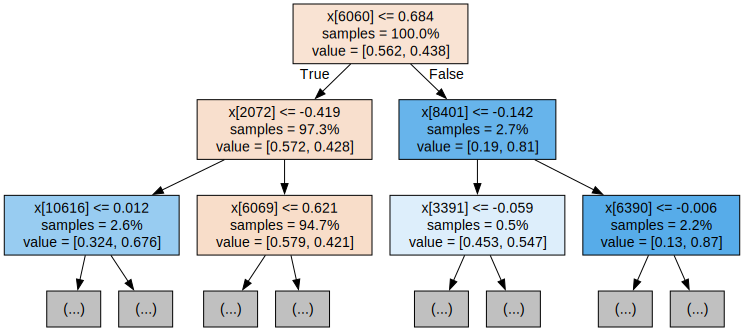

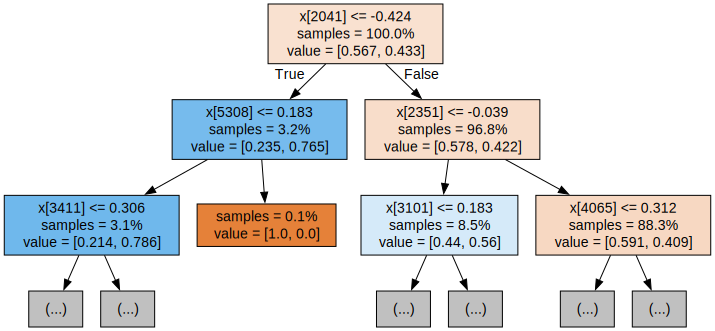

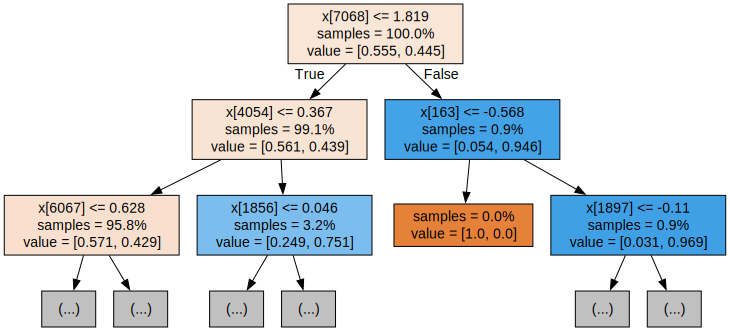

In [94]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)
